In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import pearsonr

#the film database from the assignment
table = pd.read_csv("movie.csv")

#film database we found online(https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset)
table2 =  pd.read_csv("IMDB_movies.csv")


<h2>Onderzoeksvragen:</h2>

1. In hoeverre is de omzet van een film te voorspellen op basis van de populariteit op Facebook en IMDB?
2. In hoeverre is de IMDB score van een film te voorspellen op basis van het budget en de opbrengst?
3. Kunnen we logische klusters vinden van regisseurs die winstgevende films maken of regisseurs die vaak verliesgevende films maken?

<h1> Featurevariabelen: </h1>

We hebben een aantal featurevariabelen gekozen die passen bij onze onderzoeksvragen. Het zou altijd nog kunnen dat we bepaalde variabelen toevoegen of weglaten, maar dit is onze eerste selectie.

director_name: een nominale meetwaarde waarin de naam van de regisseur staat.
 
num_voted_users: een discrete meetwaarde die ons laat zien hoeveel mensen op een film hebben gestemd op IMDb.

num_critic_for_reviews: een discrete meetwaarde die ons laat zien hoeveel critici een film hebben gerecenseerd.

num_user_for_reviews: een discrete meetwaarde die ons laat zien hoeveel IMDb gebruikers een film hebben gerecenseerd.

imdb_score: een discrete meetwaarde die de score van een film weergeeft.

movie_facebook_likes is een discrete meetwaarde die de hoeveelheid likes die een film op facebook heeft weergeeft.

budget: een continue meetwaarde die aangeeft hoeveel geld er is besteed aan het produceren van een film.

gross: een continue meetwaarde die aangeeft hoeveel omzet een film heeft gedraaid.


<h2> Table merge process </h2>



Voor dit project hebben wij een tweede dataset gevonden op Kaggle (https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset) met IMDb data. Die gaan we in het onderstaande codeblock samenvoegen met de gegeven database.

Daarvoor moeten we een aantal dingen doen. De eerste stap is om in de 2e tabel de kolom "movie_facebook_likes" toe te voegen en te vullen met NaNs, dat maakt het samenvoegen van de twee tabellen makkelijker.

Vervolgens zorgen we ervoor dat beide tabellen voor dezelfde informatie ook dezelfde colomnamen gebruiken. 

We gebruiken de IMDb ID als index. In de gegeven database is dit een ID, maar in onze database is het een link waar de ID in zit. Die trimmen we om de ID te extraheren. 

Als we dat hebben gedaan voegen we de twee databases samen en verwijderen dubbele waardes.

<h2> Table merge process </h2>

In [406]:
# the second data set has no facebook_likes so we create an empty column
table2['movie_facebook_likes'] = np.NaN

#trim both tables so we only have 
feature_table = table[['movie_title','duration', 'movie_imdb_link', 'num_voted_users', 'num_critic_for_reviews', 'num_user_for_reviews','imdb_score', 'movie_facebook_likes','budget', 'gross', 'director_name']]
feature_table2 = table2[['original_title', 'duration', 'imdb_title_id', 'votes', 'reviews_from_critics', 'reviews_from_users', 'avg_vote','movie_facebook_likes', 'budget','worlwide_gross_income', 'director' ]]


# change the movie_imdb_link to a imdb_title_id
feature_table["movie_imdb_link"]= feature_table["movie_imdb_link"].str.split("/", n = 5, expand = True)[4]
feature_table = feature_table.rename(columns={"movie_imdb_link": "imdb_title_id"})

#change the names of the columns of the second table to corresponding collumn names of the first table
feature_table2 = feature_table2.rename(columns={"avg_vote": "imdb_score", 'original_title':'movie_title', 'votes':'num_voted_users', 'worlwide_gross_income':'gross', 'reviews_from_critics': 'num_critic_for_reviews', 'reviews_from_users': 'num_user_for_reviews', 'director':'director_name'})

#append table2 to table
new_df = feature_table.append(feature_table2)

#remove duplicates from the merged tables
new_df.drop_duplicates(subset ="imdb_title_id",
                     keep = 'first', inplace = True)

# the gross and budget in the second table are in a different format so we need to come up with something to fix those
#set([str(x)[0] for x in new_df['gross']]) 
forbidden_chars = ['G', 'I', 'N', 'P', 'n']


C:\Users\emiel\AppData\Local\Temp/ipykernel_4040/3986309575.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_table["movie_imdb_link"]= feature_table["movie_imdb_link"].str.split("/", n = 5, expand = True)[4]


<h2> frequency of rounded imdb_scores in the database </h2>

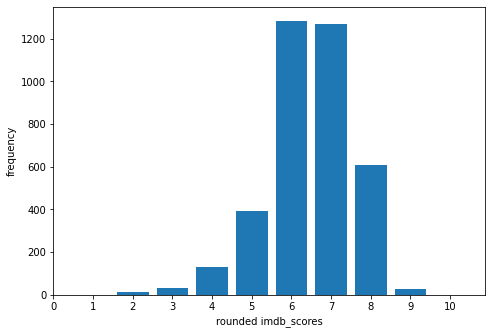

In [391]:

rounded_ratings = [round(x) for x in table.imdb_score]

x = [i+1 for i in range(10)]
y = [rounded_ratings.count(i) for i in x]

#x = table.imdb_score.value_counts().keys()
#y = table.imdb_score.value_counts().values

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

plt.xlabel('rounded imdb_scores')
plt.ylabel('frequency')

ax.bar(x,y)
plt.xticks(np.arange(0, 11, 1.0))
plt.show()

<h2> imdb_score vs movie_gross </h2>

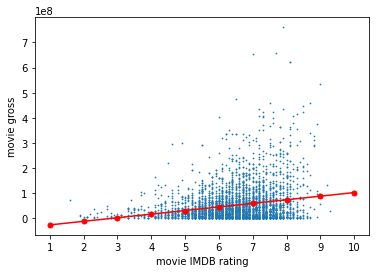

In [350]:
table = table.dropna()

x = table[['imdb_score']]
y = table[['gross']]

plt.xlabel('movie IMDB rating')
plt.ylabel('movie gross')

lm = linear_model.LinearRegression()
lm.fit(x, y)


pX = pd.DataFrame([1,2,3,4,5,6,7,8,9,10])


plt.plot([1,2,3,4,5,6,7,8,9,10],lm.predict(pX),
        marker='.', markerfacecolor='red', markersize=10, color = 'red')
plt.xticks(np.arange(0, 11, 1.0))


plt.scatter(x, y, s = .5)
plt.show()

<h2> movie_facebook_likes vs movie_gross </h2>

349000


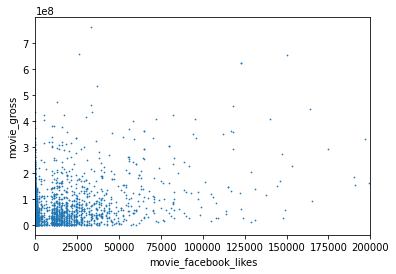

In [388]:
table = table.dropna()

x = table[['movie_facebook_likes']]
y = table[['gross']]

plt.xlabel('movie_facebook_likes')
plt.ylabel('movie_gross')


lm = linear_model.LinearRegression()
lm.fit(x, y)
plt.xlim(0,200000)

plt.scatter(x, y, s = .5)
plt.show()

<h2> imdb_score vs movie_budget </h2>

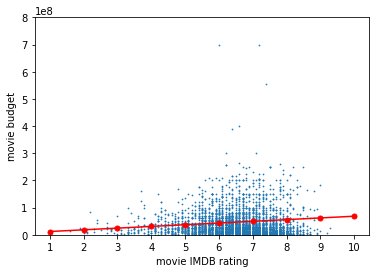

In [399]:
table = table.dropna()

x = table[['imdb_score']]
y = table[['budget']]

plt.xlabel('movie IMDB rating')
plt.ylabel('movie budget')


plt.ylim(0,800000000)

lm = linear_model.LinearRegression()
lm.fit(x, y)


pX = pd.DataFrame([1,2,3,4,5,6,7,8,9,10])


plt.plot([1,2,3,4,5,6,7,8,9,10],lm.predict(pX),
        marker='.', markerfacecolor='red', markersize=10, color = 'red')
plt.xticks(np.arange(0, 11, 1.0))


plt.scatter(x, y, s = .5)
plt.show()

<h1> Featurevariabelen: </h1>

    







    

In [ ]:
num_voted_users: Discreet

num_critic_for_reviews: Discreet

num_user_for_reviews: Discreet

budget: Continu

imdb_score: Discreet

movie_facebook_likes: Discreet

gross: Continu

director: Nominaal

    

<h2> Correlation between columns and movie gross: </h2>

<h2> Correlation between columns and movie gross: </h2>

In [88]:
table = table.dropna()

l = ['num_voted_users','num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_user_for_reviews', 'budget', 'title_year', 'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio', 'movie_facebook_likes']


for col in l:
    print(f"{col}: {pearsonr(table[col], table.gross)[0]}")


num_voted_users: 0.6249487454565548
num_critic_for_reviews: 0.4641870340045625
duration: 0.2457261977705955
director_facebook_likes: 0.1383505899808125
actor_3_facebook_likes: 0.29986381633000814
actor_1_facebook_likes: 0.1440095703653353
gross: 1.0
num_user_for_reviews: 0.544673830198518
budget: 0.099496423270246
title_year: 0.05480795298930051
actor_2_facebook_likes: 0.2528419264768792
imdb_score: 0.21473971217602245
aspect_ratio: 0.06394585497812032
movie_facebook_likes: 0.3669326605067953
